In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
faostat_df = pd.read_csv("FAOSTAT_data_en_11-19-2025.csv")   
crop_df    = pd.read_csv("Crop_recommendation.csv")          

print("FAOSTAT head:")
print(faostat_df.head())

print("\nCrop dataset head:")
print(crop_df.head())


FAOSTAT head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha   
2  Ani

In [3]:
faostat_india = faostat_df[faostat_df["Area"] == "India"].copy()

print("FAOSTAT India head:")
print(faostat_india.head())
print("FAOSTAT India shape:", faostat_india.shape)


FAOSTAT India head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha   


In [4]:
print("Before explosion shape:", faostat_india.shape)
print(faostat_india[["Item"]].head())

# split on comma and strip spaces
faostat_india["crop"] = (
    faostat_india["Item"]
      .str.split(",")
      .apply(lambda lst: [x.strip() for x in lst])
)

faostat_exploded = faostat_india.explode("crop").reset_index(drop=True)

print("\nAfter explosion shape:", faostat_exploded.shape)
print(faostat_exploded[["Item","crop"]].head())


Before explosion shape: (5940, 15)
                                                Item
0  Anise, badian, coriander, cumin, caraway, fenn...
1  Anise, badian, coriander, cumin, caraway, fenn...
2  Anise, badian, coriander, cumin, caraway, fenn...
3  Anise, badian, coriander, cumin, caraway, fenn...
4  Anise, badian, coriander, cumin, caraway, fenn...

After explosion shape: (9160, 16)
                                                Item       crop
0  Anise, badian, coriander, cumin, caraway, fenn...      Anise
1  Anise, badian, coriander, cumin, caraway, fenn...     badian
2  Anise, badian, coriander, cumin, caraway, fenn...  coriander
3  Anise, badian, coriander, cumin, caraway, fenn...      cumin
4  Anise, badian, coriander, cumin, caraway, fenn...    caraway


In [5]:
faostat_exploded = faostat_exploded.rename(columns={"Item": "item"})



crop_df = crop_df.rename(columns={"label": "crop"})

print("Crop columns after rename:", crop_df.columns)
print("FAOSTAT columns after rename:", faostat_exploded.columns)


Crop columns after rename: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'crop'], dtype='object')
FAOSTAT columns after rename: Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note', 'crop'],
      dtype='object')


In [6]:
label_to_fao = {
    "apple":      "Apples",
    "banana":     "Bananas",
    "chickpea":   "Chick peas",
    "coconut":    "Coconuts",
    "coffee":     "Coffee",
    "cotton":     "Seed cotton",
    "grapes":     "Grapes",
    "jute":       "Jute",
    "lentil":     "Lentils",
    "maize":      "Maize (corn)",
    "mango":      "Mangoes",
    "mothbeans":  "Beans",
    "muskmelon":  "Cantaloupes and other melons",
    "orange":     "Oranges",
    "papaya":     "Papayas",
    "pigeonpeas": "Pigeon peas",
    "rice":       "Rice",
    "watermelon": "Watermelons",
}


In [7]:
crop_df["FAO_name"] = crop_df["crop"].map(label_to_fao)

faostat_exploded["FAO_name"] = faostat_exploded["crop"]


crop_mapped = crop_df[~crop_df["FAO_name"].isna()].copy()

merged = faostat_exploded.merge(
    crop_mapped,
    on="FAO_name",
    how="inner",
    suffixes=("_fao", "_ml")
)

print("Merged shape:", merged.shape)
print("Unique ML crops after mapping:", merged["crop_ml"].nunique())
print(sorted(merged["crop_ml"].unique()))


Merged shape: (129600, 25)
Unique ML crops after mapping: 18
['apple', 'banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'rice', 'watermelon']


In [8]:
merged["crop"] = merged["crop_ml"]


In [21]:
merged_prod = merged[merged["Element"] == "Production"].copy() 

In [23]:
cols_keep = ["Element", "Value", "N", "P", "K",
             "temperature", "humidity", "ph", "rainfall", "crop"]
final_df = merged_prod[cols_keep].copy()
print("final_df shape:", final_df.shape)
print(final_df.head())
print(final_df.tail())


final_df shape: (43200, 10)
        Element      Value   N    P    K  temperature   humidity        ph  \
200  Production  1050000.0  24  128  196    22.750888  90.694892  5.521467   
201  Production  1050000.0   7  144  197    23.849401  94.348150  6.133221   
202  Production  1050000.0  14  128  205    22.608010  94.589006  6.226290   
203  Production  1050000.0   8  120  201    21.186674  91.134357  6.321152   
204  Production  1050000.0  20  129  201    23.410447  91.699133  5.587906   

       rainfall   crop  
200  110.431786  apple  
201  114.051249  apple  
202  116.039659  apple  
203  122.233323  apple  
204  116.077793  apple  
           Element      Value    N   P   K  temperature   humidity        ph  \
129595  Production  3626000.0   97  12  47    25.287846  89.636679  6.765095   
129596  Production  3626000.0  110   7  45    26.638386  84.695469  6.189214   
129597  Production  3626000.0   96  18  50    25.331045  84.305338  6.904242   
129598  Production  3626000.0   8

In [10]:
print("Unique crops in final_df:")
print(sorted(final_df["crop"].unique()))
print("Number of unique crops:", final_df["crop"].nunique())


Unique crops in final_df:
['apple', 'banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'rice', 'watermelon']
Number of unique crops: 18


In [11]:

final_df = merged[cols_keep].copy()

print("final_df shape:", final_df.shape)
print(final_df.head())
print(final_df.tail())

# Check unique crops
print("Unique crops in final_df:")
print(sorted(final_df["crop"].unique()))
print("Number of unique crops:", final_df["crop"].nunique())


final_df shape: (129600, 10)
          Element     Value   N    P    K  temperature   humidity        ph  \
0  Area harvested  230000.0  24  128  196    22.750888  90.694892  5.521467   
1  Area harvested  230000.0   7  144  197    23.849401  94.348150  6.133221   
2  Area harvested  230000.0  14  128  205    22.608010  94.589006  6.226290   
3  Area harvested  230000.0   8  120  201    21.186674  91.134357  6.321152   
4  Area harvested  230000.0  20  129  201    23.410447  91.699133  5.587906   

     rainfall   crop  
0  110.431786  apple  
1  114.051249  apple  
2  116.039659  apple  
3  122.233323  apple  
4  116.077793  apple  
           Element      Value    N   P   K  temperature   humidity        ph  \
129595  Production  3626000.0   97  12  47    25.287846  89.636679  6.765095   
129596  Production  3626000.0  110   7  45    26.638386  84.695469  6.189214   
129597  Production  3626000.0   96  18  50    25.331045  84.305338  6.904242   
129598  Production  3626000.0   83  23

In [12]:
print("Null counts:")
print(final_df.isna().sum())


Null counts:
Element        0
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
crop           0
dtype: int64


In [24]:
print("Duplicate rows:", final_df.duplicated().sum())
final_df = final_df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", final_df.shape)


Duplicate rows: 600
Shape after dropping duplicates: (42600, 10)


In [25]:
numeric_cols = ["Value","N","P","K","temperature","humidity","ph","rainfall"]

for col in numeric_cols:
    Q1 = final_df[col].quantile(0.25)
    Q3 = final_df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    final_df = final_df[(final_df[col] >= low) & (final_df[col] <= high)]

In [26]:
final_df.to_csv("Clean_FAOSTAT_Crop_18crops.csv", index=False)


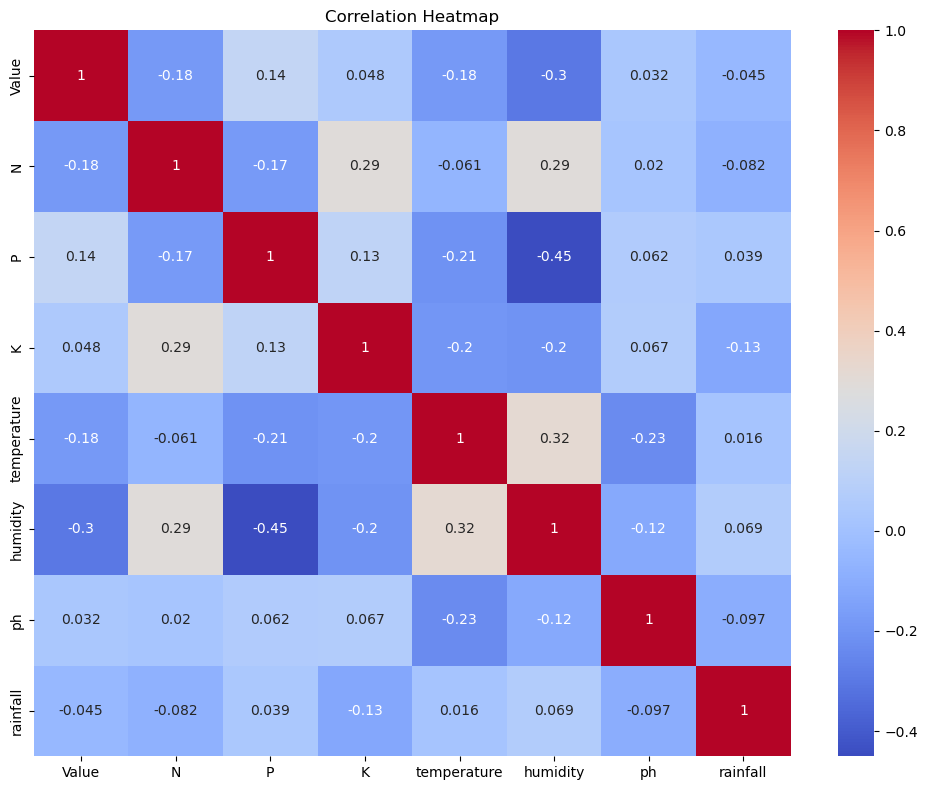

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(final_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


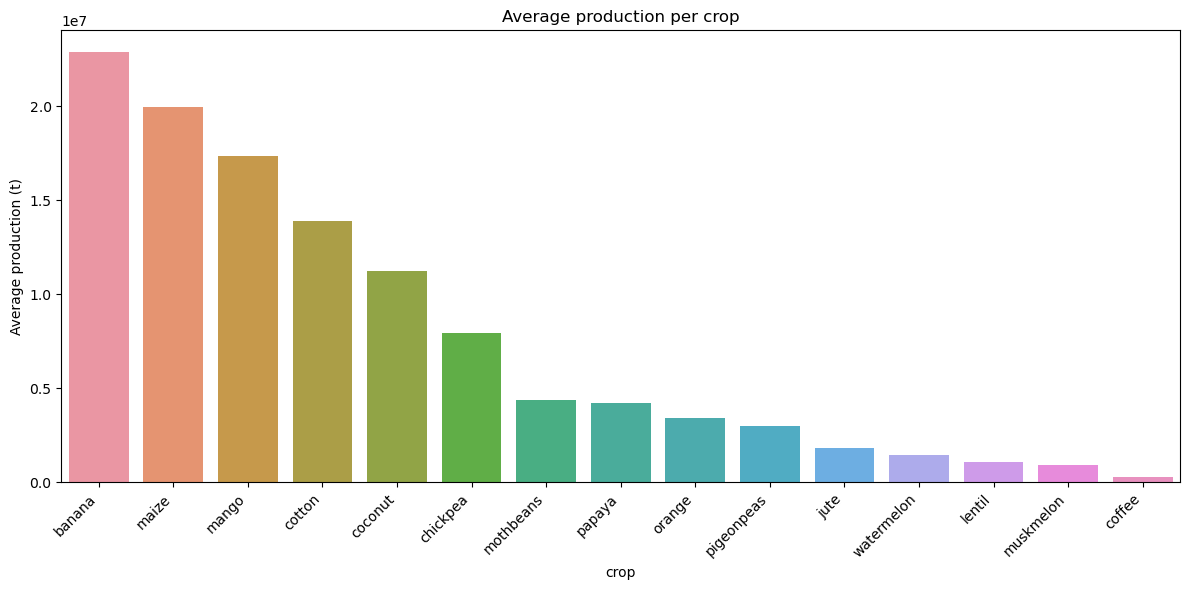

In [27]:
plt.figure(figsize=(12,6))
mean_prod = final_df.groupby("crop")["Value"].mean().sort_values(ascending=False)
sns.barplot(x=mean_prod.index, y=mean_prod.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average production (t)")
plt.title("Average production per crop")
plt.tight_layout()
plt.show()


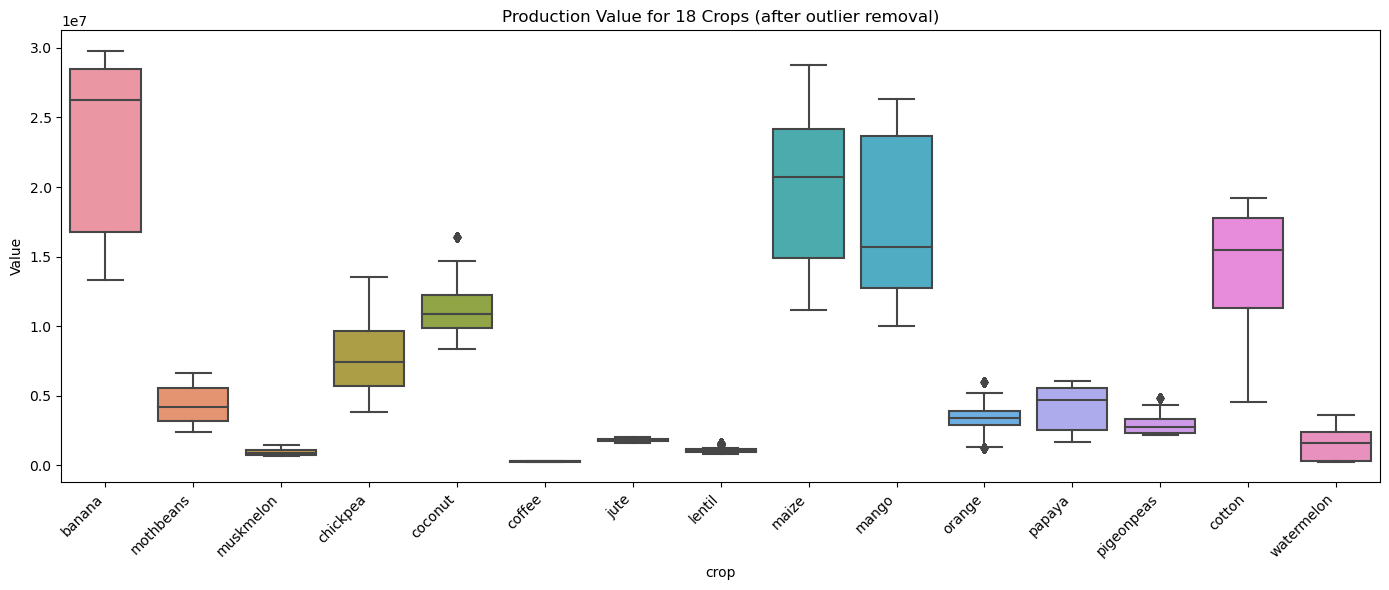

In [28]:
plt.figure(figsize=(14,6))
sns.boxplot(data=final_df, x="crop", y="Value")
plt.xticks(rotation=45, ha="right")
plt.title("Production Value for 18 Crops (after outlier removal)")
plt.tight_layout()
plt.show()


In [29]:
print(final_df["crop"].value_counts())

crop
coconut       2400
jute          2400
lentil        2400
cotton        2400
watermelon    2400
muskmelon     2300
coffee        2300
mango         2232
chickpea      2088
pigeonpeas    2016
maize         2000
banana        1700
orange        1617
papaya        1488
mothbeans     1296
Name: count, dtype: int64


In [30]:
print("Unique crops:", sorted(final_df["crop"].unique()))
print("Number of unique crops:", final_df["crop"].nunique())
print(final_df["crop"].value_counts())

Unique crops: ['banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'watermelon']
Number of unique crops: 15
crop
coconut       2400
jute          2400
lentil        2400
cotton        2400
watermelon    2400
muskmelon     2300
coffee        2300
mango         2232
chickpea      2088
pigeonpeas    2016
maize         2000
banana        1700
orange        1617
papaya        1488
mothbeans     1296
Name: count, dtype: int64
